Задача классификации. Логистическая регрессия. Проблема переобучения. Регуляризация

##univariate linear regression


In [1]:
import numpy as np
import scipy.optimize as opt
import sys
from sympy.solvers import solve
from sympy import symbols,sympify,lambdify
import matplotlib.pyplot as plt
import sympy
from tqdm import tqdm
import cv2
import imutils
import pandas as pd


import warnings
warnings.filterwarnings('ignore')

In [2]:
def sigmoid(z):
      return 1/(1+np.exp(-z))

In [80]:
class LossFunction:
  @staticmethod
  def cross_entropy(theta, X, y,lam):
    hThetaX = sigmoid(np.dot(X, theta))
    y=np.resize(y,(1,len(y)))[0]
    cross_entropy = - (np.dot(y, np.log(hThetaX)) + np.dot((1 - y), np.log(1 - hThetaX))) / len(y)

    regularization=(hThetaX**2)*(lam/(2*len(y)))
    cross_entropy+=regularization[0]

    return cross_entropy

  @staticmethod
  def cross_entropy_prime(theta,X, y,lam):
    hThetaX = sigmoid(np.dot(X, theta))
    gradient =  np.dot(X.T, (hThetaX - y)) / len(y)

    regularization=(theta*lam)/(len(y))
    gradient+=regularization[0]

    return gradient


In [90]:
class LogisticRegression:
  def __init__(self,data,classes,degree_polynomial=1,lam=0):
    self.data=data.copy()
    self.matrix_dimension=len(data.columns)
    self.classes=classes
    self.lam=lam
    self.degree_polynomial=degree_polynomial

    self.create_string_function(self.degree_polynomial)

    self.setVectors()


  def drawGraph(self,x_size=7,y_size=5,soluthion=False):
    plt.figure(figsize=(x_size, y_size))

    data0=self.data.loc[self.data[self.data.columns[2]] == 0] 
    data1=self.data.loc[self.data[self.data.columns[2]] == 1]

    plt.plot(data0[data0.columns[0]],
             data0[data0.columns[1]],
             label = self.classes[0],color="r" ,marker='x',linestyle='none')
    
    plt.plot(data1[data1.columns[0]],
             data1[data1.columns[1]],
             label = self.classes[1],color="b" ,marker='o',linestyle='none')
    
    if soluthion:
      x1=(self.data[self.data.columns[1]]).tolist()
      x1.sort()
      x2=self.count_string_function(x1)
      x1,x2=self.delete_coords_without_roots(x1,x2)
      plt.plot(x1, x2,color="y",marker='o',linestyle='none',markersize=2)

    plt.xlabel(self.data.columns[0]), plt.ylabel(self.data.columns[1])
    plt.legend()
    plt.show()

  def getPredict(self,dataset):
    function = sympify(self.string_function)
    for number_k in range(len(self.theta)):
          kn=symbols('k{}'.format(number_k))
          function=function.subs({kn:self.theta[number_k]})

    x1,x2 = symbols('x1, x2')
    predict=[]
    for data in dataset:
      function_copy=function.subs({x1:data[0],x2:data[1]})
      predict.append(0 if function_copy<0 else 1)
    return predict

  def get_tranclation_predict(self,data):
    result=self.getPredict(data)
    return [self.classes[int(i)] for i in result]

  def create_string_function(self,degree_polynomial):
      string_function='k0'
      k_n=1
      for degree_polynomial in range(1,degree_polynomial+1):
        n_x1,n_x2=degree_polynomial,0
        while n_x2<=degree_polynomial:
          string_function+='+k{}*(x1**{})*(x2**{})'.format(k_n,n_x1,n_x2)
          n_x1-=1
          n_x2+=1
          k_n+=1
      self.string_function=string_function

  def count_string_function(self,x1_real):

    function = sympify(self.string_function)

    for number_k in range(len(self.theta)):
        kn=symbols('k{}'.format(number_k))
        function=function.subs({kn:self.theta[number_k]})

    x1,x2 = symbols('x1, x2')

    print("Coords calculation")
    x2_real=[] #roots can be greater than 1 at higher powers of the equation
    for x in tqdm(x1_real):
      function_copy=function.subs({x1:x})
      roots = solve(function_copy, x2)
      roots=[root for root in roots if (type(root)!=sympy.core.add.Add)]
      x2_real.append(roots)

    #x2_real = lambdify([x1], solve(function, x2), "numpy")
    #x2_real=np.resize(x2_real,(len(x1_real),1))
    return x2_real

  def delete_coords_without_roots(self,x1,x2):
    x1_transform,x2_transform=[],[]

    for index_x,roots in enumerate(x2):
      for root in roots:
          x2_transform.append(root)
          x1_transform.append(x1[index_x])

    return x1_transform,x2_transform

  def setVectors(self):
    self.X=self.getX()
    self.Y = np.array(self.data[self.data.columns[-1:]])

    self.matrix_dimension=len(self.X[0])
    self.theta=np.resize(np.array([0 for _ in range(self.matrix_dimension)]),(self.matrix_dimension,1))


  def getX(self):
    self.x1 = np.array(self.data[self.data.columns[0]])
    self.x2 = np.array(self.data[self.data.columns[1]])

    polyvalent=[]
    for degree_polynomial in range(0,self.degree_polynomial+1):
      polyvalent+=(LogisticRegression.one_binomial_newton(degree_polynomial,self.x1,self.x2))
    polyvalent=np.hstack((polyvalent[i] for i in range (len(polyvalent))))

    return polyvalent

  @staticmethod
  def one_binomial_newton(n,x1,x2):
    polyvalent=[]
    if n==0:
      polyvalent.append(np.ones((len(x1),1)))
    else:
      n_x1,n_x2=n,0
      while n_x2<=n:
        polyvalent.append(np.resize((x1**n_x1)*(x2**(n_x2)),(len(x1),1)))
        n_x1-=1
        n_x2+=1
    return polyvalent

  def gradientDescent(self):
    y=np.resize(self.Y,(1,len(self.Y)))[0]
    result = opt.fmin_tnc(func = LossFunction.cross_entropy,            #метода Ньютона сопряженных градиентов
                          x0 = self.theta,
                          fprime = LossFunction.cross_entropy_prime,
                          args = (self.X, y,self.lam))
    theta_optimized = result[0]
    self.theta=theta_optimized

  def accuracy(self):
    test_y=self.getPredict(np.array(self.data[self.data.columns[:-1]]))
    train_y=np.resize(self.Y,(1,len(self.Y)))[0]
    accuracy=0
    for i in range(len(train_y)):
      accuracy+=abs(test_y[i]-train_y[i])
    accuracy=(1-accuracy/len(train_y))*100

    return accuracy

In [85]:
data_exam = pd.read_csv("ex2data1.txt", header=None)
data_exam.column=['Exam1_score','Exam2_score','res']
data_exam.head(5)

,0,1,2
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


k0+k1*(x1**1)*(x2**0)+k2*(x1**0)*(x2**1)


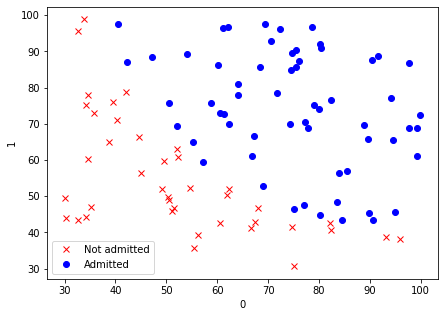

F([array([0]), array([0]), array([0])])=0.6931471805599453
F'([array([0]), array([0]), array([0])])=([array([-0.1]), array([-12.00921659]), array([-11.26284221])])
theta=[-25.161318638875745, 0.2062315889914217, 0.20147148602481324]
Coords calculation


100%|██████████| 100/100 [00:05<00:00, 17.06it/s]


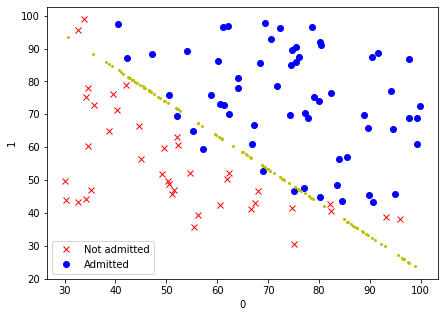

student with points 45 and 85 was Admitted in university
accuracy=89.0


In [91]:
predict=LogisticRegression(data_exam,
                         classes=["Not admitted","Admitted"],
                         degree_polynomial=1
                         )
print(predict.string_function)
predict.drawGraph()

print('F({})={}'.format(list(predict.theta),LossFunction.cross_entropy(predict.theta,predict.X, predict.Y,0)[0]))
print("F'({})=({})".format(list(predict.theta),list(LossFunction.cross_entropy_prime(predict.theta,predict.X, predict.Y,0))))

predict.gradientDescent()
print('theta={}'.format(list(predict.theta)))
predict.drawGraph(soluthion=True)

x1,x2=45,85
print('student with points {} and {} was {} in university'.format(x1,x2,predict.get_tranclation_predict([[x1,x2]])[0]
                                                                  ))
print('accuracy={}'.format(predict.accuracy()))


Получили границу решения, разделяющие классы

In [92]:
microchips = pd.read_csv("ex2data2.txt", header=None)
microchips.column=['test1','test2','res']  #Accepted','Regected
microchips.head(5)

,0,1,2
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


k0+k1*(x1**1)*(x2**0)+k2*(x1**0)*(x2**1)+k3*(x1**2)*(x2**0)+k4*(x1**1)*(x2**1)+k5*(x1**0)*(x2**2)+k6*(x1**3)*(x2**0)+k7*(x1**2)*(x2**1)+k8*(x1**1)*(x2**2)+k9*(x1**0)*(x2**3)+k10*(x1**4)*(x2**0)+k11*(x1**3)*(x2**1)+k12*(x1**2)*(x2**2)+k13*(x1**1)*(x2**3)+k14*(x1**0)*(x2**4)+k15*(x1**5)*(x2**0)+k16*(x1**4)*(x2**1)+k17*(x1**3)*(x2**2)+k18*(x1**2)*(x2**3)+k19*(x1**1)*(x2**4)+k20*(x1**0)*(x2**5)+k21*(x1**6)*(x2**0)+k22*(x1**5)*(x2**1)+k23*(x1**4)*(x2**2)+k24*(x1**3)*(x2**3)+k25*(x1**2)*(x2**4)+k26*(x1**1)*(x2**5)+k27*(x1**0)*(x2**6)


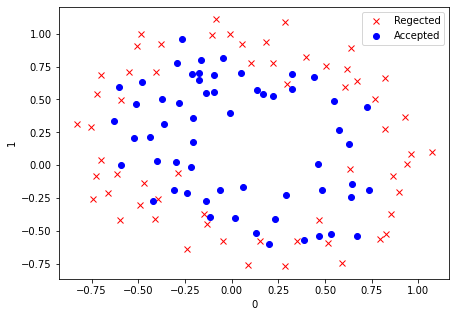

F(theta)=0.6995031127633352
F'(theta)=([array([0.00847458]), array([0.01878809]), array([7.77711864e-05]), array([0.05034464]), array([0.01150133]), array([0.03766485]), array([0.01835599]), array([0.00732393]), array([0.00819244]), array([0.02347649]), array([0.03934862]), array([0.00223924]), array([0.01286005]), array([0.00309594]), array([0.03930282]), array([0.01997075]), array([0.00432983]), array([0.00338644]), array([0.00583822]), array([0.00447629]), array([0.03100798]), array([0.03103124]), array([0.0010974]), array([0.00631571]), array([0.0004085]), array([0.00726504]), array([0.00137646]), array([0.03879364])])
Coords calculation


100%|██████████| 118/118 [00:30<00:00,  3.88it/s]


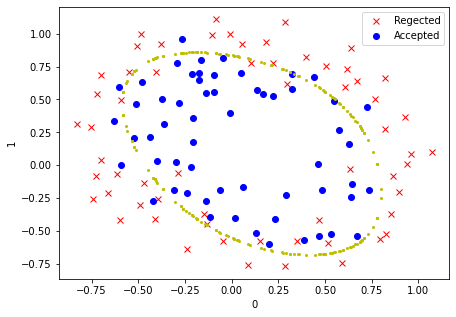

microchip with tests -0.85196 and -0.36769 was Regected
accuracy=84.7457627118644


In [94]:
predict=LogisticRegression(microchips,
                         classes=["Regected","Accepted"],
                         degree_polynomial=6,
                         lam=1)

print(predict.string_function)

predict.drawGraph()

print('F(theta)={}'.format(LossFunction.cross_entropy(predict.theta,predict.X, predict.Y,6)[0]))
print("F'(theta)=({})".format(list(LossFunction.cross_entropy_prime(predict.theta,predict.X, predict.Y,6))))

predict.gradientDescent()

predict.drawGraph(soluthion=True) #It is not recommended to enable it, because it is a long calculation


x1,x2=-0.85196,-0.36769
print('microchip with tests {} and {} was {}'.format(x1,x2,predict.get_tranclation_predict([[x1,x2]])[0]
                                                                  ))
print('accuracy={}'.format(predict.accuracy()))


##OVERfitting (lam=0)


Coords calculation


100%|██████████| 118/118 [00:25<00:00,  4.60it/s]


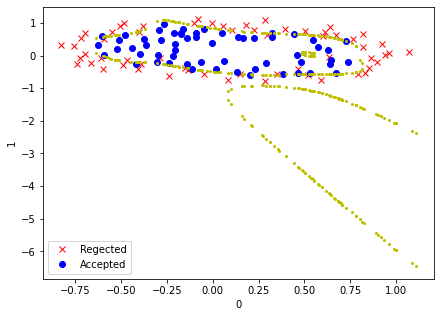

In [96]:
predict=LogisticRegression(microchips,
                         classes=["Regected","Accepted"],
                         degree_polynomial=6,
                         lam=0)

predict.gradientDescent()

predict.drawGraph(soluthion=True)


##UNDERfitting (lam=100)

Coords calculation


100%|██████████| 118/118 [00:51<00:00,  2.27it/s]


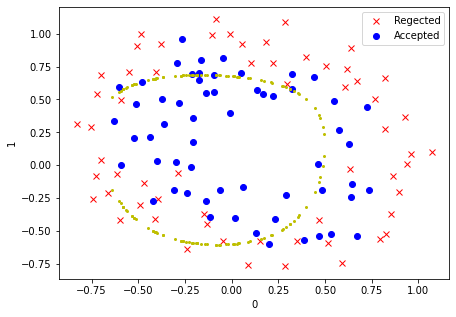

In [67]:
predict=LogisticRegression(microchips,
                         classes=["Regected","Accepted"],
                         degree_polynomial=6,
                         lam=100)

predict.gradientDescent()
predict.drawGraph(soluthion=True)

lam=30

Coords calculation


100%|██████████| 118/118 [15:19<00:00,  7.79s/it]


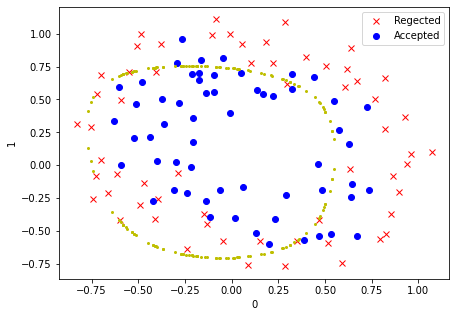

In [68]:
predict=LogisticRegression(microchips,
                         classes=["Regected","Accepted"],
                         degree_polynomial=6,
                         lam=30)

predict.gradientDescent()

predict.drawGraph(soluthion=True)

overfitting can be combated by reducing the number of iterations

Handwritten digit recognition

In [97]:
class MNIST_classification:
  def __init__(self,data,lam=0):
    self.matrix_dimension=len(data.columns)
    self.data=data.copy()
    self.lam=lam

  def train(self):
    self.creat_binary_cassifiers()

  def getPredict(self,data):
    ones_vector = np.ones((len(data),1))
    data=np.hstack((ones_vector,data))

    predict=[]
    for X in data:
      softmax=[]
      for theta in self.weights:
        h=sigmoid(np.dot(X,theta.T))
        softmax.append(h)
      predict.append(softmax.index(max(softmax)))
    return predict

  def creat_binary_cassifiers(self):
    self.weights=[]
    print("Creat binary cassifiers")
    for number in tqdm(range(10)):
      self.setVectors(number)
      theta=self.gradientDescent()
      self.weights.append(theta)

  def setVectors(self,number):
    self.X = np.array(self.data[self.data.columns[:-1]])
    ones_vector = np.ones((len(self.X),1))
    self.X=np.hstack((ones_vector,self.X))
    self.Y = np.array(self.data[self.data.columns[-1:]])
    self.Y=self.transorm_Y(self.Y,number)
    self.Y=np.resize(self.Y,(1,len(self.Y)))[0]

    self.theta=np.resize(np.array([0 for _ in range(self.matrix_dimension)]),(self.matrix_dimension,1))

  def transorm_Y(self,Y,number):
    for i in range(len(Y)):
      if Y[i]!=number:
        Y[i]=0
      else:
        Y[i]=1
    return Y


  def gradientDescent(self):

    result = opt.fmin_tnc(func = LossFunction.cross_entropy,
                          x0 = self.theta,
                          fprime = LossFunction.cross_entropy_prime,
                          args = (self.X, self.Y,self.lam))[0]
    return result

  def accuracy(self):
    test_y=self.getPredict(np.array(self.data[self.data.columns[:-1]]))

    train_y=self.data[self.data.columns[-1:]]
    train_y=np.resize(train_y,(1,len(train_y)))[0]

    accuracy=0
    for i in range(len(train_y)):
      accuracy+=abs(test_y[i]-train_y[i])
    accuracy=(1-accuracy/len(train_y))*100
    return accuracy




In [98]:
mnist = pd.read_csv("ex2data3.txt", header=None)
#microchips.column=['test1','test2','res']  #Accepted','Regected
mnist.head(5)

,0,1,2,3,4,5,6,7,8,9,...,391,392,393,394,395,396,397,398,399,400
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
X_test = np.array(mnist[mnist.columns[:-1]])

In [100]:
predict=MNIST_classification(mnist)
predict.train()
print('accuracy={}'.format(predict.accuracy()))

Creat binary cassifiers


100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


accuracy=90.22


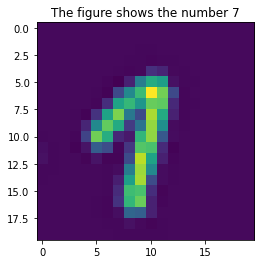

In [102]:
def test(image):
  gray=np.resize(image,(20,20))
  gray = imutils.rotate(gray, angle=240)[:,::-1]
  plt.imshow(gray)
  plt.title("The figure shows the number {}".format(predict.getPredict([image])[0]))
  plt.show()


test(X_test[3501])
